In [1]:
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt

import datetime as dt
import scipy.stats as stats

In [2]:
#Load the dataframe for emails
emails=pd.read_csv('emails.csv')

In [3]:
#Recode the variables as about opening and clicking
replace_input=[True,False]
replace_output=[1,0]
emails['open']=emails['open'].replace(replace_input, replace_output)
emails['click']=emails['click'].replace(replace_input, replace_output)
emails=emails.drop(['customer_id'], axis=1)

#Set a counter so that each email will be counted when the dataframe starts to get lumped
emails['total_sent']=1

In [4]:
#Create a time-of-day variable ignoring the date, this will be useful later
emails['time']=0
for i in range(len(emails)):
    emails['time'][i]=emails['date'][i][11:15]+str('0')

C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/440685578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails['time'][i]=emails['date'][i][11:15]+str('0')
C:\Users\Dzousep\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
#This will make the indexing easier
emails.index=emails['date'].astype('datetime64[ns]')
emails=emails.drop(['date'], axis=1)
emails['last_open']=emails['last_open'].astype('datetime64[ns]')

In [6]:
#Resample the entire dataframe by 1-hour intervals
emails_resampled=emails.resample('60T', origin='start_day').sum() 

In [7]:
emails_resampled=emails_resampled.reset_index()
emails_resampled['day']=emails_resampled['date'].dt.strftime('%y-%m-%d')

In [8]:
#Will remove the first and the last logged day, as they are not complete. (Utilising these days could have been useful, but I only remembered how to do it later.)
emails_resampled=emails_resampled.loc[emails_resampled['day']!='20-03-01']
emails_resampled=emails_resampled.loc[emails_resampled['day']!='21-10-25']

In [9]:
#This step will create a NumPy array for each day that is complete
days=emails_resampled['day'].unique()

open_arr=np.zeros(shape=(602, 24))
click_arr=np.zeros(shape=(602, 24))
total_arr=np.zeros(shape=(602, 24))

for day in range(len(days)):
    df=emails_resampled.loc[emails_resampled['day']==days[day]]
    open_arr[day]=df['open']
    click_arr[day]=df['click']
    total_arr[day]=df['total_sent']

#Now we reshape the array contain WEEKS, that is - 86 weeks, 7 days each (7x24=168)
open_arr=np.reshape(open_arr, newshape=(86,168))
click_arr=np.reshape(click_arr, newshape=(86,168))
total_arr=np.reshape(total_arr, newshape=(86,168))

In [10]:
#Create total week arrays
open_arr_sum=np.sum(open_arr, axis=0)
click_arr_sum=np.sum(click_arr, axis=0)
total_arr_sum=np.sum(total_arr, axis=0)

#Create relative values per week
relative_open=open_arr_sum/total_arr_sum
relative_click=click_arr_sum/total_arr_sum

C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/2180248560.py:7: RuntimeWarning: invalid value encountered in true_divide
  relative_open=open_arr_sum/total_arr_sum
C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/2180248560.py:8: RuntimeWarning: invalid value encountered in true_divide
  relative_click=click_arr_sum/total_arr_sum


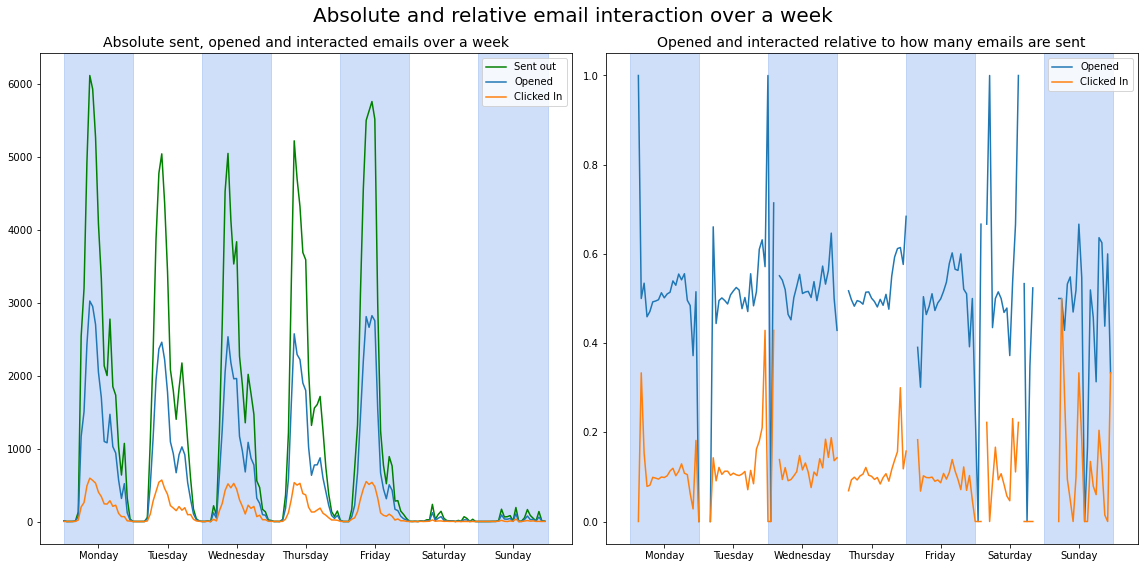

In [11]:
#This will plot the absolute and relative values for all emails. 
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot(total_arr_sum, label='Sent out', color='green')
ax[0].plot(open_arr_sum, label='Opened')
ax[0].plot(click_arr_sum, label='Clicked In')
ax[0].set_title('Absolute sent, opened and interacted emails over a week', fontsize=14)
ax[0].legend()

ax[1].plot(relative_open, label='Opened')
ax[1].plot(relative_click, label='Clicked In')
ax[1].set_title('Opened and interacted relative to how many emails are sent', fontsize=14)
ax[1].legend()

ax_day_borders=[0,24,48,72,96,120,144,168]
ax_day_mids=[12, 36, 60, 84, 108, 132, 156]
ax_days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

for i in [0,1]:
    ax[i].axvspan(0, 24, color='cornflowerblue', alpha=0.3)
    ax[i].axvspan(48,72, color='cornflowerblue', alpha=0.3)
    ax[i].axvspan(96, 120, color='cornflowerblue', alpha=0.3)
    ax[i].axvspan(144, 168, color='cornflowerblue', alpha=0.3)
    ax[i].set_xticks(ticks=ax_day_mids)
    ax[i].set_xticklabels(labels=ax_days)


fig.suptitle('Absolute and relative email interaction over a week', fontsize=20)
plt.tight_layout()

Data needs more cleaning - Weekends should be removed, as should veru early mornings and very late evenings

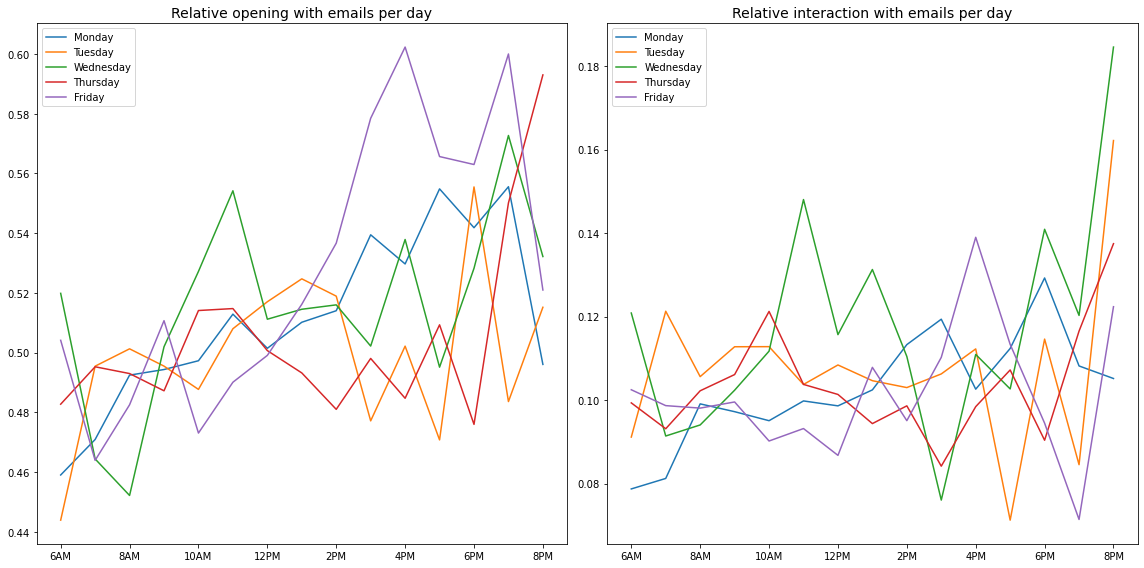

In [12]:
#Let's choose only data from 6AM to 8PM for working days

#First, empty dataframes for containing them
open_df=pd.DataFrame()
click_df=pd.DataFrame()

work_days=['Monday','Tuesday','Wednesday','Thursday','Friday'] #We will exclude Saturday and Sunday because they have very little data overall
work_days_idx=[0,24,48,72,96]

for work_day in range(len(work_days)):
    work_day_relative_open=relative_open[work_days_idx[work_day]+6:work_days_idx[work_day]+21] #Only from 6AM to 8PM
    open_df[work_day]=work_day_relative_open

    work_day_relative_click=relative_click[work_days_idx[work_day]+6:work_days_idx[work_day]+21]
    click_df[work_day]=work_day_relative_click

open_df.columns=work_days
click_df.columns=work_days


fig, ax = plt.subplots(1, 2, figsize=(16,8))

for day in work_days:
    ax[0].plot(open_df[day], label=day)
    ax[1].plot(click_df[day], label=day)

for i in [0,1]:
    ax[i].set_xticks(ticks=[0,2,4,6,8,10,12,14])
    ax[i].set_xticklabels(labels=['6AM','8AM','10AM','12PM','2PM','4PM','6PM','8PM'])
    ax[i].legend()

ax[0].set_title('Relative opening with emails per day', fontsize=14)
ax[1].set_title('Relative interaction with emails per day', fontsize=14)
plt.tight_layout()


That's a little better. Seems that there is a trend upwards - the later the email is sent, the higher the interaction. 

P-value of the difference of variance in opening the email between days = 0.2059810946555417


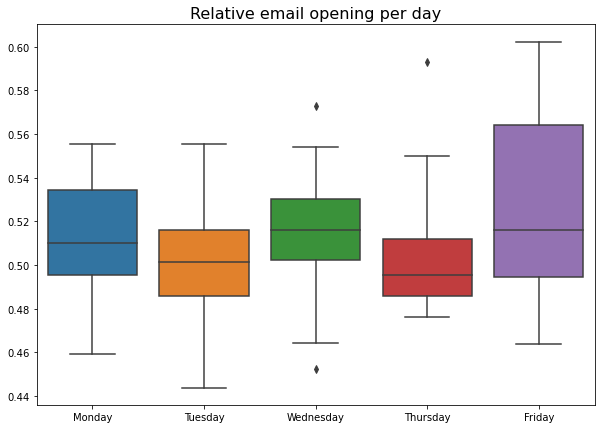

In [13]:
#This will check if the variance in opening of emails per day is different by day. It will also check it with a one-way ANOVA test

plt.figure(figsize=(10,7))
sb.boxplot(data=open_df)
plt.title('Relative email opening per day', fontsize=16)
f_val,p_val=stats.f_oneway(open_df['Monday'],open_df['Tuesday'],open_df['Wednesday'], open_df['Thursday'], open_df['Friday'])
print('P-value of the difference of variance in opening the email between days = '+str(p_val))

P-value of the difference of variance in interacting in the email between days = 0.1270996721447192


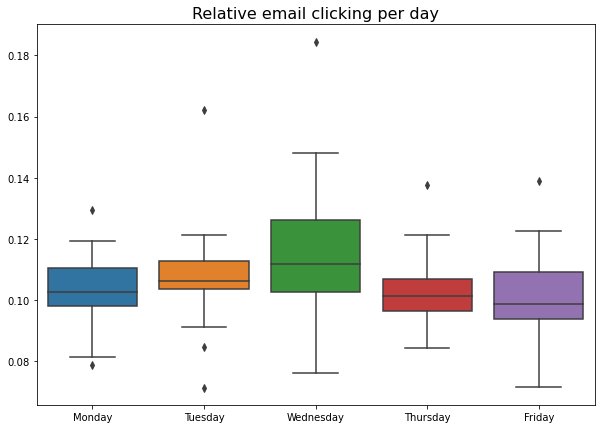

In [14]:
#This will do the same, but for relative clicking in the email

plt.figure(figsize=(10,7))
sb.boxplot(data=click_df)
plt.title('Relative email clicking per day', fontsize=16)
f_val,p_val=stats.f_oneway(click_df['Monday'],click_df['Tuesday'],click_df['Wednesday'], click_df['Thursday'], click_df['Friday'])
print('P-value of the difference of variance in interacting in the email between days = '+str(p_val))

None of the p-values are significant. This doesn't negate the small effect sizes. 

### Now I want to plot the relative opening and clicking in a single day, regardless of which day it is. Additionally, data will be grouped into 10 minute intervals.

In [15]:
#Group dataframe by times

grp=emails.groupby(by='time').sum()
grp['relative_open']=grp['open']/grp['total_sent']
grp['relative_click']=grp['click']/grp['total_sent']
grp.head()

,open,click,total_sent,relative_open,relative_click
time,,,,,
00:00,6,2,13,0.461538,0.153846
00:10,8,0,11,0.727273,0.000000
00:20,8,2,12,0.666667,0.166667
00:30,5,1,7,0.714286,0.142857
00:40,1,1,3,0.333333,0.333333


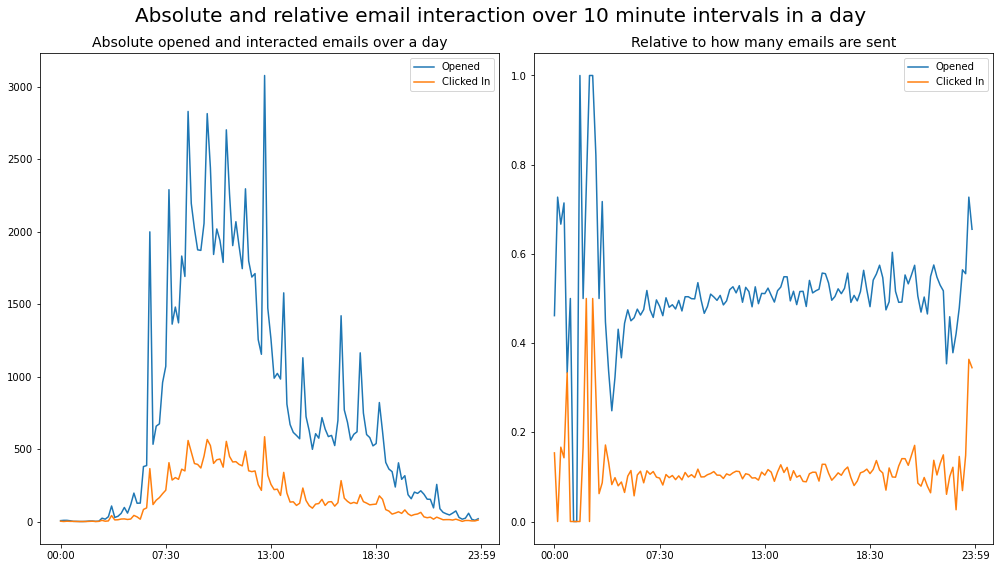

In [16]:
times=['00:00','07:30','13:00','18:30','23:59']
ticks=[0, 33, 66, 99, 132]

fig, ax = plt.subplots(1, 2, figsize=(14,8))
ax[0].plot(grp['open'], label='Opened')
ax[0].plot(grp['click'], label='Clicked In')
ax[0].set_title('Absolute opened and interacted emails over a day', fontsize=14)
ax[0].set_xticks(ticks=ticks)
ax[0].set_xticklabels(times)
ax[0].legend()

ax[1].plot(grp['relative_open'], label='Opened')
ax[1].plot(grp['relative_click'], label='Clicked In')
ax[1].set_title('Relative to how many emails are sent', fontsize=14)
ax[1].set_xticks(ticks=ticks)
ax[1].set_xticklabels(times)
ax[1].legend()

fig.suptitle('Absolute and relative email interaction over 10 minute intervals in a day', fontsize=20)
plt.tight_layout()

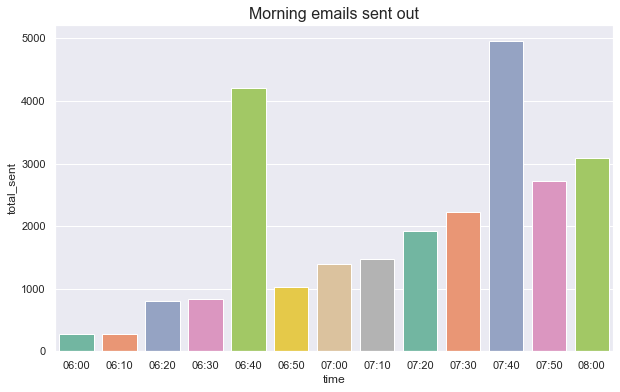

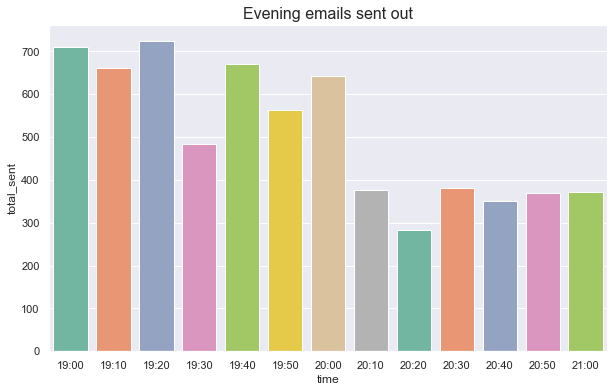

In [17]:
#Again, there seems to be little valuable data at early morning or late evening

#Figure out cutoffs
#I want to check at which time of the morning and evening separately does the amount of total sent emails change substantially
morning=grp.loc['06:00':'08:00']
evening=grp.loc['19:00':'21:00']

sb.set(rc={"figure.figsize":(10, 6)}) #width, height

sb.barplot(data=morning, x=morning.index, y='total_sent', palette='Set2')
plt.title('Morning emails sent out', fontsize=16)
plt.show()

sb.barplot(data=evening, x=evening.index, y='total_sent', palette='Set2')
plt.title('Evening emails sent out', fontsize=16)
plt.show()

It seems that there is a sharp rise in sent emails at 06:20, and a sharp drop after 20:00.  I will cut the data to include only the time of day from 06:20 until 20:00

In [18]:
grp_cut=grp.loc['06:20':'20:00']
grp_cut

,open,click,total_sent,relative_open,relative_click
time,,,,,
06:20,379,83,796,0.476131,0.104271
06:30,386,94,834,0.462830,0.112710
06:40,1999,365,4207,0.475160,0.086760
06:50,533,117,1029,0.517979,0.113703
07:00,658,147,1387,0.474405,0.105984
...,...,...,...,...,...
19:20,344,51,725,0.474483,0.070345
19:30,238,58,483,0.492754,0.120083
19:40,405,67,671,0.603577,0.099851


[Text(0, 0, '06:20'),
 Text(20, 0, '09:40'),
 Text(41, 0, '13:10'),
 Text(61, 0, '16:30'),
 Text(82, 0, '20:00')]

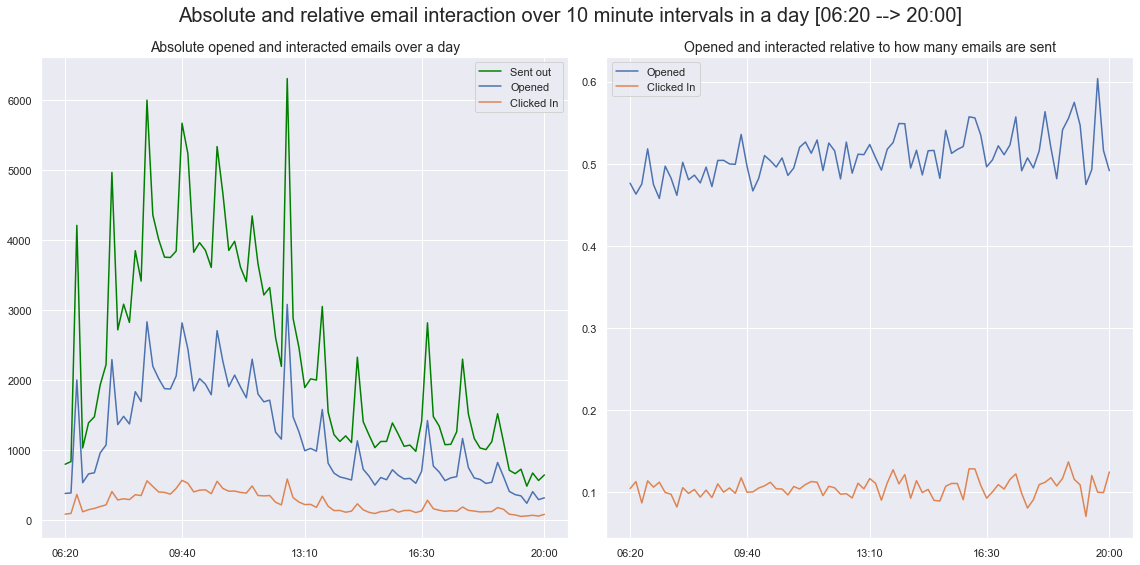

In [19]:
#Same as above, but only for the chosen interval

fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot(grp_cut['total_sent'], label='Sent out', color='green')
ax[0].plot(grp_cut['open'], label='Opened')
ax[0].plot(grp_cut['click'], label='Clicked In')
ax[0].set_title('Absolute opened and interacted emails over a day', fontsize=14)
ax[0].legend()

ax[1].plot(grp_cut['relative_open'], label='Opened')
ax[1].plot(grp_cut['relative_click'], label='Clicked In')
ax[1].set_title('Opened and interacted relative to how many emails are sent', fontsize=14)
ax[1].legend()

fig.suptitle('Absolute and relative email interaction over 10 minute intervals in a day [06:20 --> 20:00]', fontsize=20)
plt.tight_layout()

#Set the X-axis labels
indexes=np.linspace(0,82,5).astype(int)
indexes=indexes.tolist()
tags=(grp_cut.index).tolist()
tags=[tags[i] for i in indexes]

ax[0].set_xticks(ticks=indexes)
ax[0].set_xticklabels(tags)

ax[1].set_xticks(ticks=indexes)
ax[1].set_xticklabels(tags)

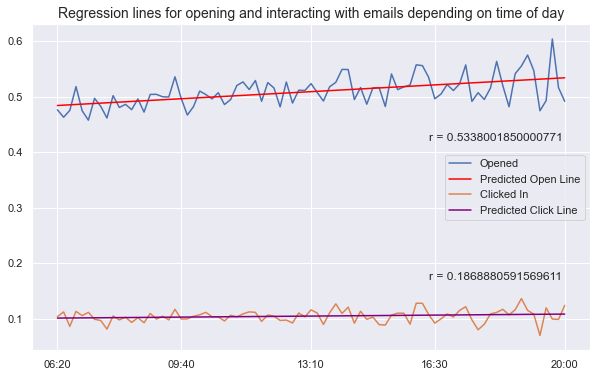

In [20]:
#Let's see if regression coefficients come up significant

from scipy.stats import linregress

plt.plot(grp_cut['relative_open'], label='Opened')
slope, intercept, r, p, se = linregress(x=range(len(grp_cut)), y=grp_cut['relative_open'])
plt.plot(intercept+slope*range(len(grp_cut)), label='Predicted Open Line', color='red')
text=('r = '+str(r))
plt.text(x=60, y=0.42, s=text)

plt.plot(grp_cut['relative_click'], label='Clicked In')
slope, intercept, r, p, se = linregress(x=range(len(grp_cut)), y=grp_cut['relative_click'])
plt.plot(intercept+slope*range(len(grp_cut)), label='Predicted Click Line', color='purple')
text=('r = '+str(r))
plt.text(x=60, y=0.17, s=text)

plt.title('Regression lines for opening and interacting with emails depending on time of day', fontsize=14)

#Set the X-axis labels
plt.xticks(ticks=indexes, labels=tags)

#Show the legend
plt.legend()

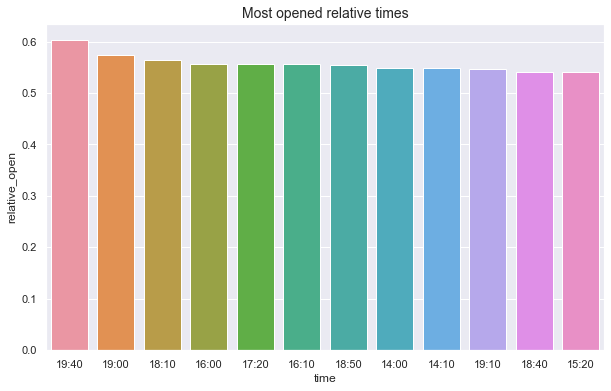

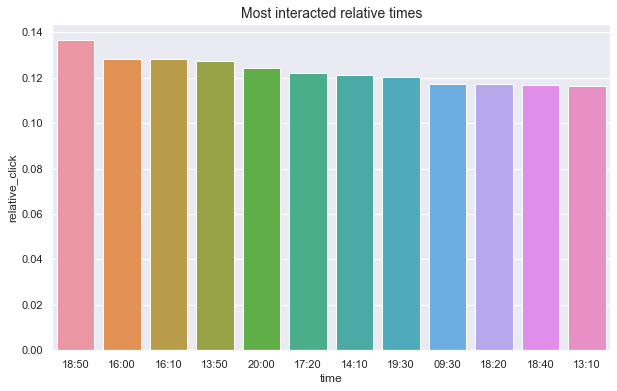

In [21]:
#Plot the most opened and interacted with times of day

by_open=grp_cut.sort_values(by='relative_open', ascending=False)[0:12]
by_interact=grp_cut.sort_values(by='relative_click', ascending=False)[0:12]

sb.barplot(data=by_open, x=by_open.index, y='relative_open')
plt.title('Most opened relative times', fontsize=14)
plt.show()

sb.barplot(data=by_interact, x=by_interact.index, y='relative_click')
plt.title('Most interacted relative times', fontsize=14)
plt.show()

Evening seems to be the most interacted with time of day

In [22]:
#Let's check the differences in template groups

#Append all email templates and template groups to the main dataframe
info=pd.read_csv('email_info.csv')
groups=pd.read_csv('email_template_groups.csv')

info.index=info['email_id']
groups.index=groups['email_template_id']


emails=emails.reset_index()

emails['template']=0
for i in range(len(emails)):
    emails['template'][i]=info.loc[emails['email_id'][i]]['email_template_id']

emails['group']=0
for j in range(len(emails)):
    emails['group'][j]=groups.loc[emails['template'][j]]['email_template_group']

C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/2283105179.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails['template'][i]=info.loc[emails['email_id'][i]]['email_template_id']
C:\Users\Dzousep\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/2283105179.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [23]:
emails

,date,email_id,last_open,last_click,open,click,total_sent,time,template,group
0,2021-08-11 07:50:00,XJ-222951510,2021-08-11 21:35:00,NaN,1,0,1,07:50,T0159,Educational
1,2021-07-01 06:07:00,XJ-222932815,NaT,NaN,0,0,1,06:00,T0157,Engagement
2,2021-10-07 07:45:00,XJ-222980459,NaT,NaN,0,0,1,07:40,T0159,Educational
3,2021-09-23 12:26:00,XJ-222978917,NaT,NaN,0,0,1,12:20,T0159,Educational
4,2021-07-27 14:47:00,XJ-222956026,2021-08-06 08:28:00,NaN,1,0,1,14:40,T0155,Educational
...,...,...,...,...,...,...,...,...,...,...
204052,2020-07-23 10:54:00,XJ-222482928,NaT,NaN,0,0,1,10:50,T0084,Educational
204053,2020-07-23 10:51:00,XJ-222482816,2020-07-23 14:03:00,2020-07-23 13:50:00,1,1,1,10:50,T0084,Educational
204054,2020-07-23 11:36:00,XJ-222482166,NaT,NaN,0,0,1,11:30,T0084,Educational
204055,2020-07-23 11:13:00,XJ-222482042,2020-07-25 11:50:00,NaN,1,0,1,11:10,T0084,Educational


C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/3460421579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_resampled['time'][i]=group_resampled['date'][i].time()


P-value of the difference of variance in opening the email between days = 0.7319515497339195


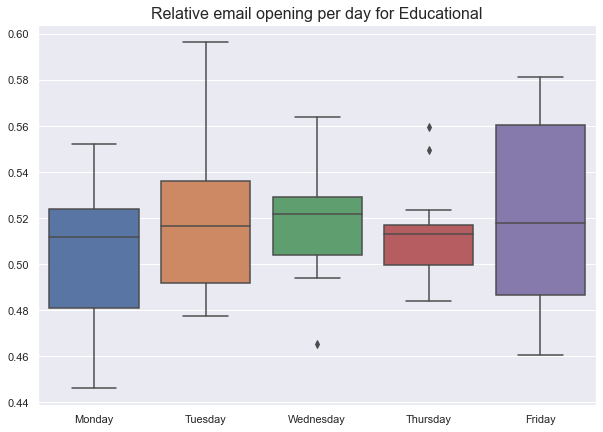

P-value of the difference of variance in interacting in the email between days = 0.10107292786417536


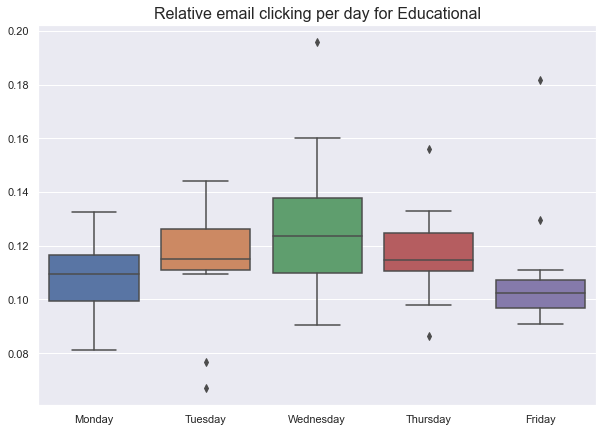

C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/3460421579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_resampled['time'][i]=group_resampled['date'][i].time()


P-value of the difference of variance in opening the email between days = 0.012865651222162797


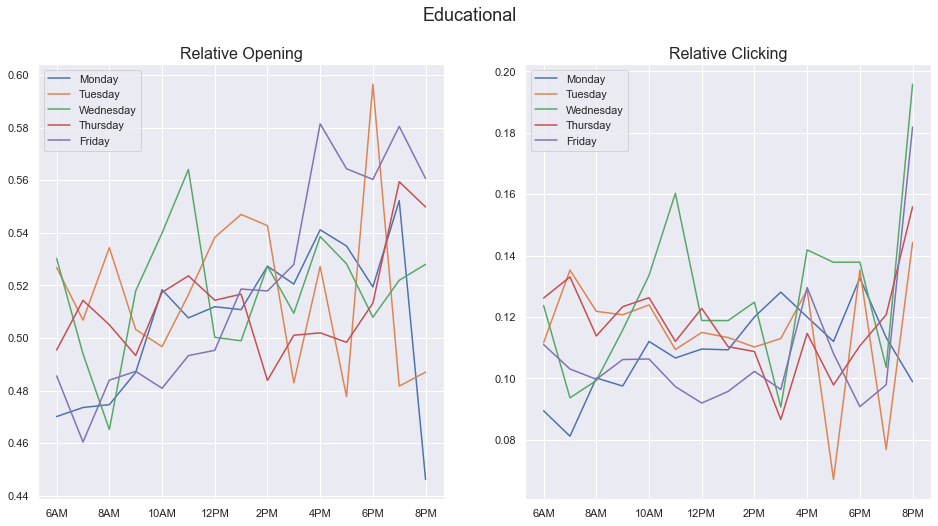

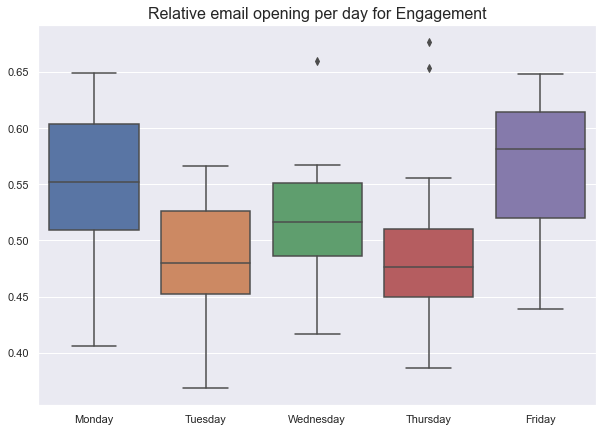

P-value of the difference of variance in interacting in the email between days = 0.20761463349468354


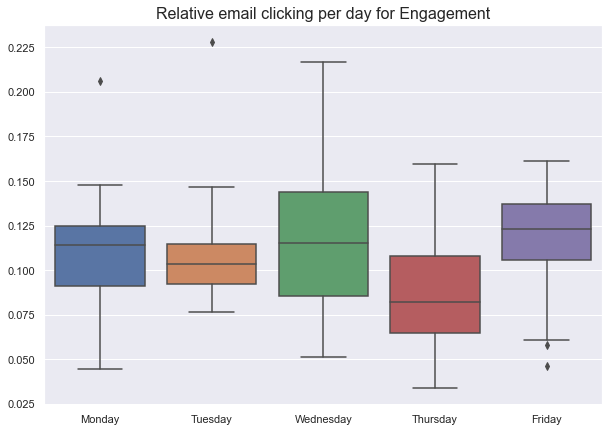

C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/3460421579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_resampled['time'][i]=group_resampled['date'][i].time()


P-value of the difference of variance in opening the email between days = 0.45537748766913777


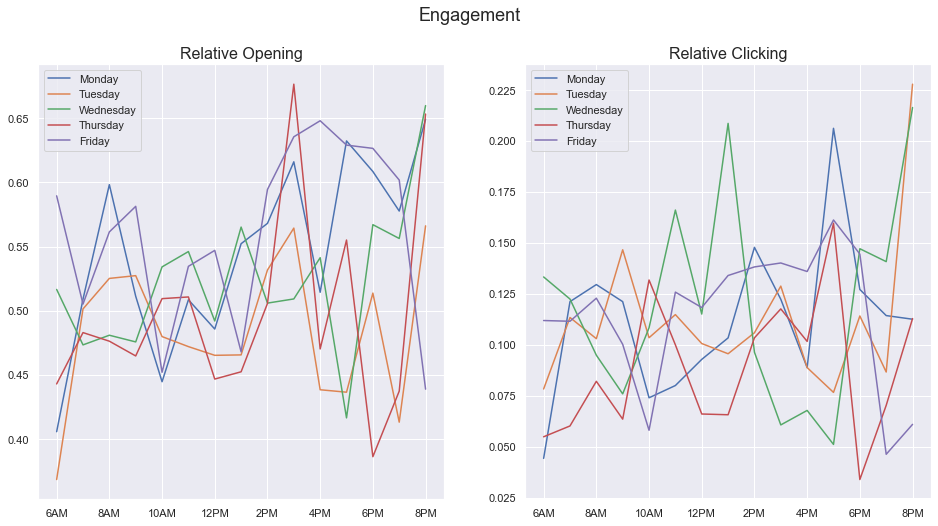

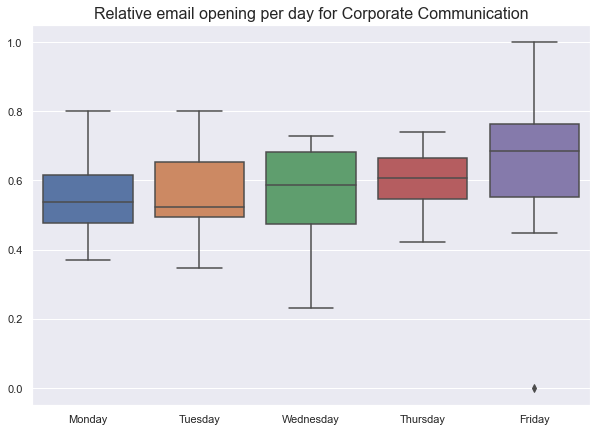

P-value of the difference of variance in interacting in the email between days = 0.14852469530219917


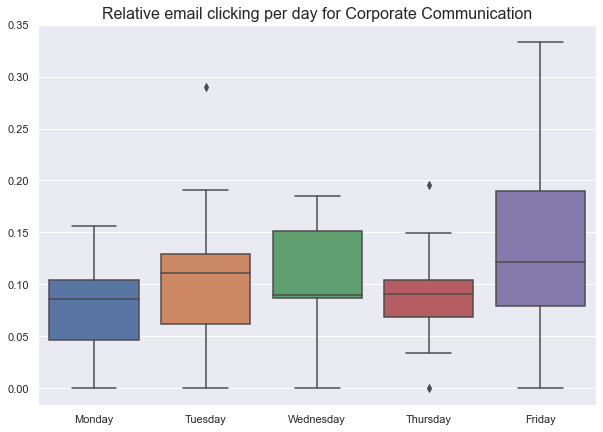

C:\Users\Dzousep\AppData\Local\Temp/ipykernel_15004/3460421579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_resampled['time'][i]=group_resampled['date'][i].time()


P-value of the difference of variance in opening the email between days = 0.8782567712528673


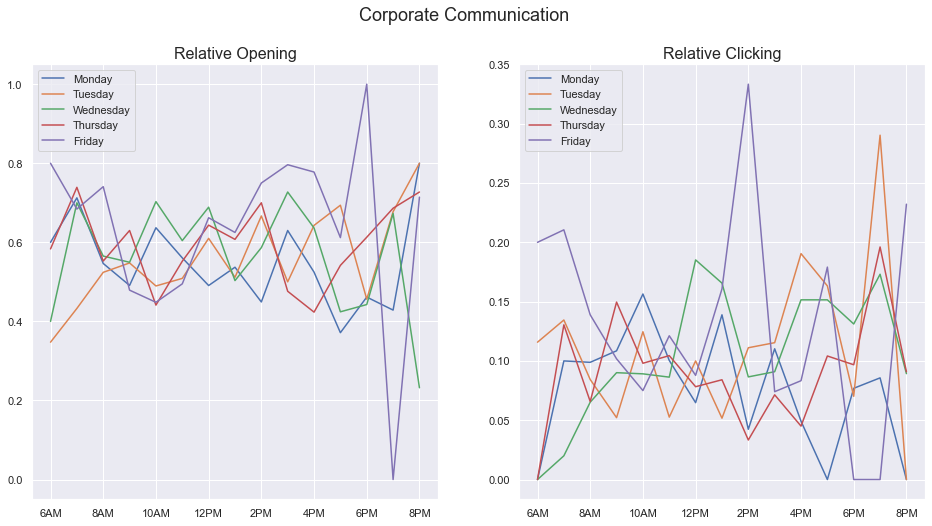

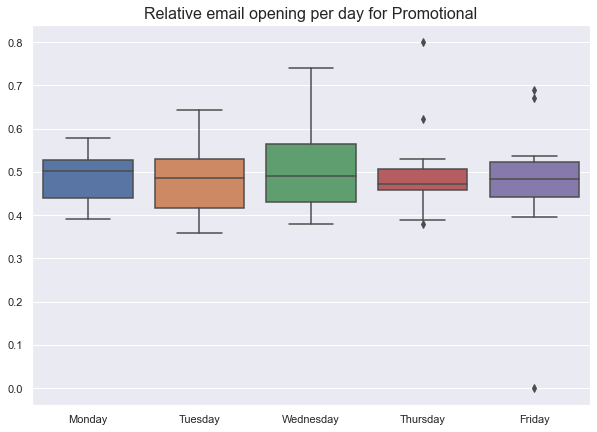

P-value of the difference of variance in interacting in the email between days = 0.8967424685041767


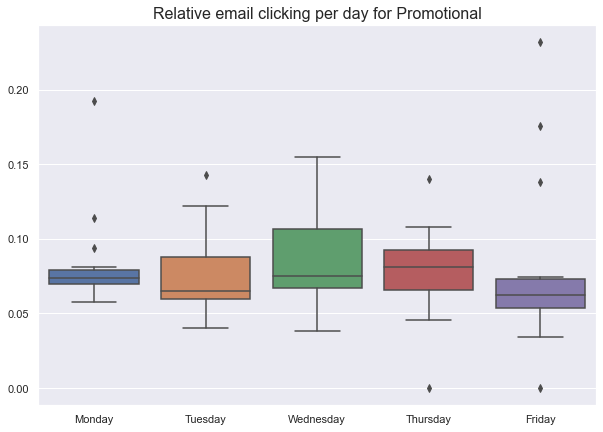

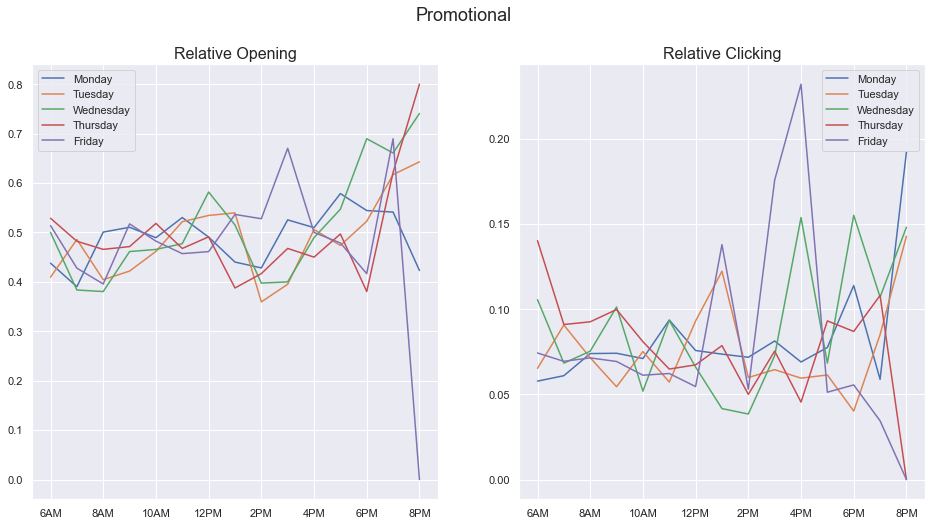

In [24]:
#Final step - plot all times per template group

template=emails['group'].unique()

for temp in template:
    group=emails.loc[emails['group']==temp]
    group.index=group['date']

    group_resampled=group.resample('60T', origin='start_day').sum()
    group_resampled=group_resampled.reset_index()

    group_resampled['time']=0
    for i in range(len(group_resampled)):
        group_resampled['time'][i]=group_resampled['date'][i].time()

    group_resampled['dayOfWeek'] = group_resampled['date'].dt.day_name()

    open_df=pd.DataFrame()
    click_df=pd.DataFrame()

    for day in work_days:
        group_resampled_day=group_resampled.loc[group_resampled['dayOfWeek']==day].groupby(by='time').sum()
        group_resampled_day=group_resampled_day.iloc[6:21]

        group_resampled_day['relative_open']=group_resampled_day['open']/group_resampled_day['total_sent']
        group_resampled_day['relative_click']=group_resampled_day['click']/group_resampled_day['total_sent']

        open_df[day]=group_resampled_day['relative_open']
        click_df[day]=group_resampled_day['relative_click']
    
    open_df=open_df.reset_index()
    click_df=click_df.reset_index()
    open_df=open_df.replace(np.nan,0)
    click_df=click_df.replace(np.nan,0)

    plt.figure(figsize=(10,7))
    sb.boxplot(data=open_df)
    plt.title('Relative email opening per day for '+temp, fontsize=16)
    f_val,p_val=stats.f_oneway(open_df['Monday'],open_df['Tuesday'],open_df['Wednesday'], open_df['Thursday'], open_df['Friday'])
    print('P-value of the difference of variance in opening the email between days = '+str(p_val))
    plt.show()
    plt.close()

    plt.figure(figsize=(10,7))
    sb.boxplot(data=click_df)
    plt.title('Relative email clicking per day for '+temp, fontsize=16)
    f_val,p_val=stats.f_oneway(click_df['Monday'],click_df['Tuesday'],click_df['Wednesday'], click_df['Thursday'], click_df['Friday'])
    print('P-value of the difference of variance in interacting in the email between days = '+str(p_val))
    plt.show()
    plt.close()


    fig, ax = plt.subplots(1, 2, figsize=(16,8))

    for day in work_days:
        ax[0].plot(open_df[day], label=day)
        ax[1].plot(click_df[day], label=day)

    ax[0].set_title('Relative Opening', fontsize=16)
    ax[1].set_title('Relative Clicking', fontsize=16)

    for i in [0,1]:
        ax[i].set_xticks(ticks=[0,2,4,6,8,10,12,14])
        ax[i].set_xticklabels(labels=['6AM','8AM','10AM','12PM','2PM','4PM','6PM','8PM'])
        ax[i].legend()

    fig.suptitle(temp, fontsize=18)



In [28]:
!jupyter nbconvert --execute --to html cantab.ipynb

[NbConvertApp] Converting notebook cantab.ipynb to html
[NbConvertApp] Writing 2337968 bytes to cantab.html
